In [1]:
#for timing every cell
%load_ext autotime
import tensorflow as tf
import numpy as np
#keras is a platform for Neural Networks which runs over tensorflow
#Input is for Instantiate the tensor(array) defining its shape
#Dense represents fully connected layer
from keras.layers import Input, Dense
#Model is an api it represents the Neural network model
from keras.models import Model
#matplotlib for plotting
import matplotlib.pyplot as plt
#For Using Tensorboard to show how loss is changing
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [2]:
#reading csv file
a=np.genfromtxt('data_for_clustering.csv', delimiter=',')
#removing last NAN value
a=a[:-1]
print(a[1])
#trimming the data
x=a[20*250:250*910]
#reshaping into(x,250)
x=x.reshape(-1,250)
#Mean subtraction window wise
#taking mean
me=np.mean(x,axis=1)
#subtracting mean
x=(x.T-me).T
#scaling
maxi,mini=np.max(x,axis=1),np.min(x,axis=1)
x=(x.T/(maxi-mini)).T
x.shape
#x_test=x[700:]
#x=x[:700]


x=x.reshape(890,250)

39963.59
time: 2.4 s


In [19]:
#using tensorboard 
%tensorboard
name="dense model"
tensorboard=TensorBoard(log_dir='logs/{}'.format(name))
%tensorboard --logdir {name}

time: 997 µs


UsageError: Line magic function `%tensorboard` not found.


In [4]:
#creating a deep dense neural network
#deciding number of encoding dimentions
encoding_dim = 20
# this is our input placeholder
input_img = Input(shape=(250,))
# "encoded" is the encoded representation of the input
#adding a dense layer with 125 nodes , linear activation, input dimension as input_img
encoded0=Dense(125,activation='linear')(input_img)
#adding a dense layer with 60 nodes , linear activation, input dimention as encoded0
encoded1=Dense(60,activation='linear')(encoded0)
#adding a dense layer with encoding_dim nodes , linear activation, input dimention as encoded1
encoded = Dense(encoding_dim, activation='linear')(encoded1)

# "decoded" is the lossy reconstruction of the input
#adding a dense layer with 60 nodes , linear activation, input dimention as encoding dim
decoded0=Dense(60,activation='linear')(encoded)
decoded1=Dense(125,activation='linear')(decoded0)
#final decoding layer
decoded = Dense(250, activation='linear')(decoded1)
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
# this model maps an input to its encoded representation
#passing start to encoded
encoder = Model(input_img, encoded)
# create a placeholder for an encoded (10-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last third layer of the autoencoder model with 10 dimentions
decoder_layer = autoencoder.layers[-3]
#naming the last and second last layer
decoder_layer1 = autoencoder.layers[-1]
decoder_layer2 = autoencoder.layers[-2]
# create the decoder model
#defining placeholders
encoded_input1 = Input(shape=(125,))
encoded_input2 = Input(shape=(60,))
#first decoding layer
decoder2 = Model(encoded_input2, decoder_layer2(encoded_input2))
#second decoding layer
decoder1 = Model(encoded_input1, decoder_layer1(encoded_input1))
decoder = Model(encoded_input, decoder_layer(encoded_input))
#compiling the model and varifying the connectivity, optimizer is adam and loss function is mean squared error
autoencoder.compile(optimizer='adam', loss='mse')#binary_crossentropy

Instructions for updating:
Colocations handled automatically by placer.
time: 126 ms


In [5]:
#training the autoencoder , first x is input, 2nd x for output, number of epochs=50, batch size(number of samples sent at once)
autoencoder.fit(x,x,
epochs=50,
batch_size=10,validation_split=0.1, callbacks=[tensorboard])

Instructions for updating:
Use tf.cast instead.
Train on 801 samples, validate on 89 samples
Epoch 1/50
801/801 [==============================] - 0s 324us/step - loss: 0.0315 - val_loss: 0.0198
Epoch 2/50
801/801 [==============================] - 0s 151us/step - loss: 0.0145 - val_loss: 0.0133
Epoch 3/50
801/801 [==============================] - 0s 149us/step - loss: 0.0099 - val_loss: 0.0096
Epoch 4/50
801/801 [==============================] - 0s 148us/step - loss: 0.0082 - val_loss: 0.0083
Epoch 5/50
801/801 [==============================] - 0s 151us/step - loss: 0.0076 - val_loss: 0.0079
Epoch 6/50
801/801 [==============================] - 0s 151us/step - loss: 0.0071 - val_loss: 0.0077
Epoch 7/50
801/801 [==============================] - 0s 148us/step - loss: 0.0070 - val_loss: 0.0077
Epoch 8/50
801/801 [==============================] - 0s 151us/step - loss: 0.0069 - val_loss: 0.0076
Epoch 9/50
801/801 [==============================] - 0s 148us/step - loss: 0.0069 - val_lo

time: 7.65 s


In [6]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(name, histogram_freq=1)
#encoded_layer gives encoded input
encoded_layer=encoder.predict(x)
# getting decoded output
#first decoder 10 to 60
decoded_output1=decoder.predict(encoded_layer)
#second decoder 60 to 120
decoded_output2=decoder2.predict(decoded_output1)
#final decoder 120 to  250
decoded_output2=decoder1.predict(decoded_output2)


time: 121 ms


In [10]:
#checking encoded layer
encoded_layer.shape

(890, 20)

time: 997 µs


In [11]:
print(x[0].shape)
print(decoded_output2[0].shape)

(250,)
(250,)
time: 2 ms


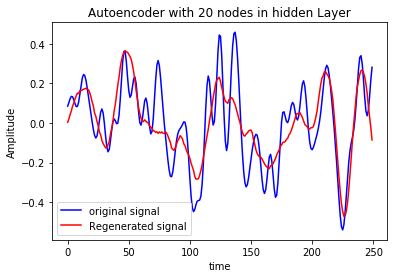

time: 161 ms


In [24]:
#plotting the graph for comparison
import matplotlib.pyplot as plt
#%matplotlib inline shows how to indent the graph
%matplotlib inline
#q= sample number to show
q=101
#adding title
plt.title('Autoencoder with 20 nodes in hidden Layer')
#plotting original signal, x axis-0 to 249, y axis is x[q],label name,colour
plt.plot(range(250),x[q],label='original signal', color='b')
#plotting decoded signal, x axis-0 to 249, y axis is x[q],label name,colour
plt.plot(range(250),decoded_output2[q],label='Regenerated signal',color='r')
plt.xlabel('time')
plt.ylabel('Amplitude')
#legend is used for showing mapping with its colour(right box at top)
plt.legend()


In [13]:
#saving encoded layer 
#np.savetxt('compressed_data20-1.csv',encoded_layer,delimiter=',')

Error in callback <function LineWatcher.stop at 0x000001C03F9B1840> (for post_run_cell):


AssertionError: 

# describing the architecture of the network and getting its weights

In [14]:
for layer in autoencoder.layers:
    weights = layer.get_weights()

time: 65.8 ms


In [18]:
autoencoder.summary()
#weights[1]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 125)               31375     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                7560      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_4 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_5 (Dense)              (None, 125)               7625      
_________________________________________________________________
dense_6 (Dense)              (None, 250)               31500     
Total para

In [16]:
config=autoencoder.get_config()
#print(config['layers'])
for layer in config['layers']:
    print(layer)

{'name': 'input_1', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 250), 'dtype': 'float32', 'sparse': False, 'name': 'input_1'}, 'inbound_nodes': []}
{'name': 'dense_1', 'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'units': 125, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'inbound_nodes': [[['input_1', 0, 0, {}]]]}
{'name': 'dense_2', 'class_name': 'Dense', 'config': {'name': 'dense_2', 'trainable': True, 'units': 60, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_in

# plotting encoded layers and actual inputs getting some matching

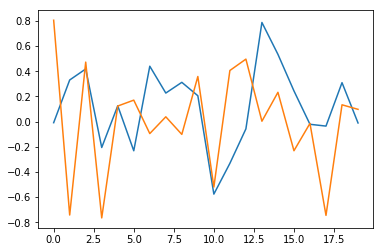

time: 143 ms


In [17]:
plt.plot(range(encoding_dim),encoded_layer[11])
plt.plot(range(encoding_dim),encoded_layer[10])
#plt.plot(range(10),encoded_layer[12])

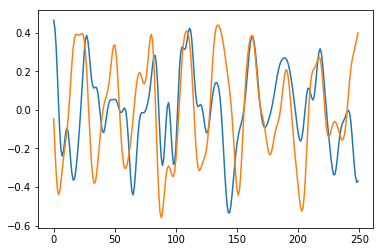

time: 158 ms


In [8]:
plt.plot(range(250),x[11])
plt.plot(range(250),x[10])
#plt.plot(range(250),x[12])

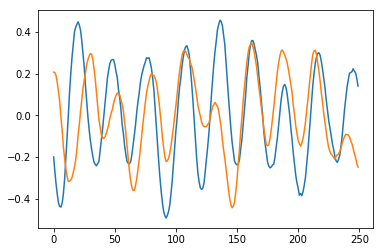

time: 123 ms


In [9]:
plt.plot(range(250),decoded_output2[10])
plt.plot(range(250),decoded_output2[11])
#plt.plot(range(250),decoded_output2[2])

# tensorboard

In [ ]:
import os
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

# saving the model

In [ ]:
autoencoder.save('Dense model.h5')

In [ ]:
#loading back
from keras.models import load_model
new_model=load_model('Dense model.h5')
new_model.summary()